In [1]:
from fastai.vision.all import *
import cv2
import torchvision

import albumentations as A

In [2]:
path = Path('D:/Datasets/TN_SC/')
images = path/'imageCOPY'
masks = path/'maskCOPY'
image_items = get_image_files(images)
mask_items = get_image_files(masks)
get_msk = lambda o: path/'maskCOPY'/f'{o.stem}{o.suffix}'

In [3]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [27]:
#Using multiple albumentations
train_tfms = A.OneOf([
                A.RGBShift(p=0.25),
                A.CropNonEmptyMaskIfExists(height=256, width=256, p=0.25),
                A.RandomGridShuffle(grid=(4, 4), p=0.25),
                    ], p=1.0)

alb_tfms = Transform(SegmentationAlbumentationsTransform(train_tfms))

In [28]:
batch_tfms = [Resize(128), IntToFloatTensor(div_mask=255), Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor, RandomResizedCrop(224, min_scale=0.35),
             SegmentationAlbumentationsTransform(train_tfms)]

binary = DataBlock(blocks=(ImageBlock, MaskBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_msk,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

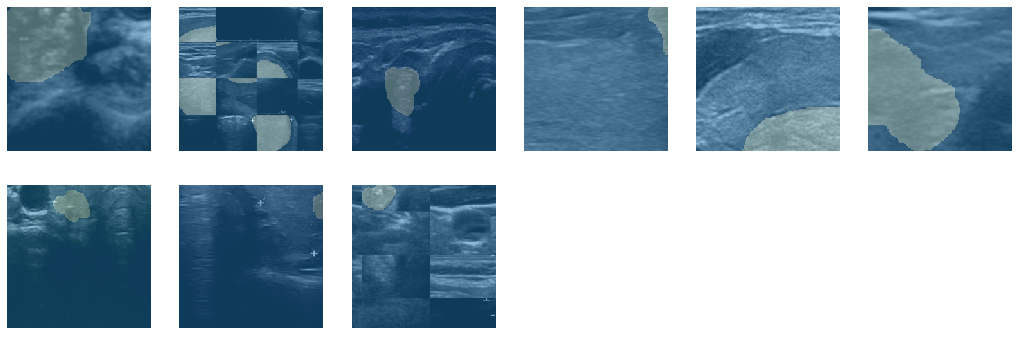

In [29]:
dls = binary.dataloaders(images, bs=12, num_workers=0)
dls.show_batch(nrows=2, ncols=6)

In [30]:
config = unet_config(self_attention=True, act_cls=Mish)
dice = Dice()
jacard = JaccardCoeff()
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
#model = torchvision.models.segmentation.fcn_resnet50(pretrained=True, n_out=2)
model.train()

class GetResult(Callback):
    def after_pred(self):
        self.learn.pred = self.pred['out']

learn = Learner(dls, model, metrics=[dice, jacard], config=config, cbs=[GetResult(), ShowGraphCallback(), ActivationStats()]).to_fp16()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.360501,0.321478,0.000000,0.000000,38:01


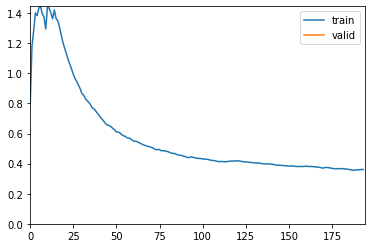

In [9]:
learn.fit_flat_cos(1, 1e-2)

In [32]:
tfms = [[PILImage.create], [get_msk, PILMask.create]]

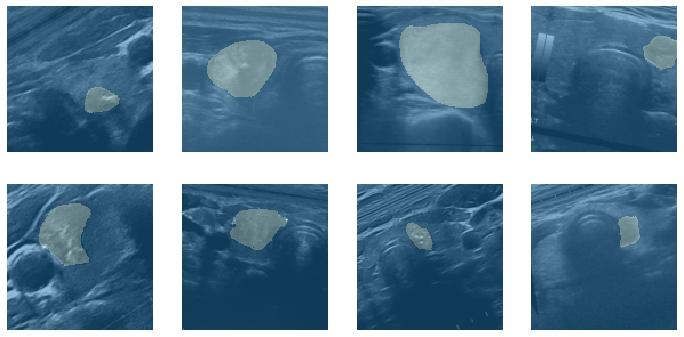

In [33]:
cv_dsets = Datasets(image_items, tfms)
dls = cv_dsets.dataloaders(bs=8, after_item=[Resize(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(A.ShiftScaleRotate(p=1))])

dls.show_batch()

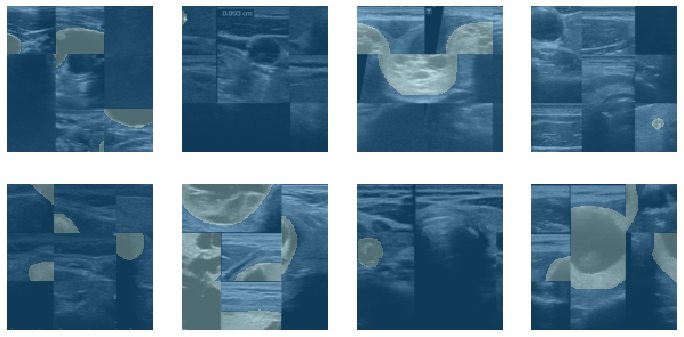

In [35]:
cv_dsets = Datasets(image_items, tfms)
dls = cv_dsets.dataloaders(bs=8, after_item=[Resize(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(A.RandomGridShuffle(grid=(3, 3), p=1))])

dls.show_batch()

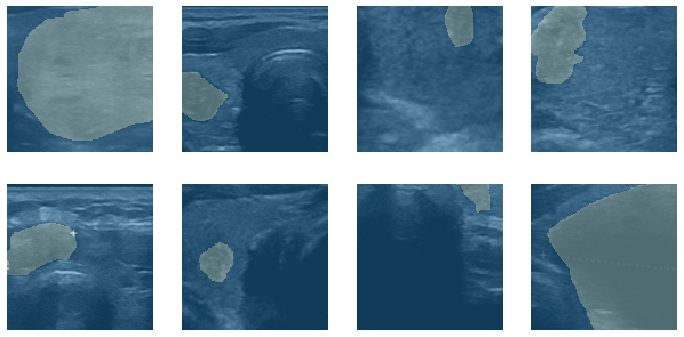

In [42]:
cv_dsets = Datasets(image_items, tfms)
dls = cv_dsets.dataloaders(bs=8, after_item=[Resize(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(A.CropNonEmptyMaskIfExists(height=256, width=256, p=1))])

dls.show_batch()

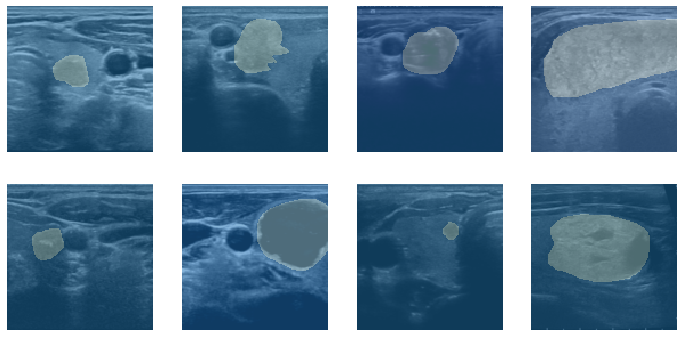

In [44]:
cv_dsets = Datasets(image_items, tfms)
dls = cv_dsets.dataloaders(bs=8, after_item=[Resize(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(A.RGBShift(p=0.25))])

dls.show_batch()